# Generate a new appropriate dataset

In [1]:
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import configparser
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import List
from toolbox.printing import warn, ldebug
import shutil

# config
config = configparser.ConfigParser()
config.read('./config.ini')
LABELBOX_DATASET_FOLDER = config["PATHS"]["LABELBOX_DATASET"]
MASKRCNN_DATASET_FOLDER = config["PATHS"]["MASKRCNN_DATASET"]
LB_API_KEY = config['SECRETS']['LABELBOX_API_KEY']
LB_PROJECT_ID = config['SECRETS']['LABELBOX_PROJECT_ID']
CLASS_TO_COLOR = {
        "edge": [int(c) for c in config["DISPLAY"]["COLOR_EDGE"].split(' ')],
        "crack": [int(c) for c in config["DISPLAY"]["COLOR_CRACK"].split(' ')],
        "boulder": [int(c) for c in config["DISPLAY"]["COLOR_BOULDER"].split(' ')],
        "rough_patch": [int(c) for c in config["DISPLAY"]["COLOR_ROUGH_PATCH"].split(' ')],
    }

In [2]:
def check_if_labelbox_dataset_exists() -> bool:
    """Checks if the dataset already exists."""
    return os.path.exists(LABELBOX_DATASET_FOLDER)

def check_if_masckrcnn_dataset_exists() -> bool:
    """Checks if the dataset already exists."""
    return os.path.exists(MASKRCNN_DATASET_FOLDER)

def get_masks(image_number: int) -> list:
    """Gets the masks for a given image number."""
    masks = []
    img_folder = os.path.join(LABELBOX_DATASET_FOLDER, str(image_number))
    for mask_path in os.listdir(img_folder):
        if mask_path.endswith(".png") and mask_path.startswith("mask"):
            mask = Image.open(os.path.join(img_folder, mask_path))
            masks.append(mask)
    return masks

def get_classes(image_number: int) -> List[str]:
    """Gets the classes for a given image number."""
    classes = []
    img_folder = os.path.join(LABELBOX_DATASET_FOLDER, str(image_number))
    with open(os.path.join(img_folder, "classes.txt"), "r") as f:
        classes = f.read().split("\n")
    return classes

In [3]:
def generate_maskrcnn_dataset():
    # Check if the mask r-cnn dataset exists
    # if check_if_masckrcnn_dataset_exists():
    #     print('Mask R-CNN dataset already exists')
    #     return

    # Create an 'images' subfolder containing all 'image.png' files from the labelbox dataset.
    # Images are saved as 'image_index.png' with image_index being the index of the image.

    # Create the 'images' subfolder in the new dataset folder
    new_images_folder = os.path.join(MASKRCNN_DATASET_FOLDER, "images")
    os.makedirs(new_images_folder, exist_ok=True)


    # Create a 'masks' subfolder containing one 'p' (palette) type 'mask_image_index.png' mask for each image.
    new_masks_folder = os.path.join(MASKRCNN_DATASET_FOLDER, "masks")
    os.makedirs(new_masks_folder, exist_ok=True)


    # Iterate over subfolders in the existing dataset
    for subfolder_name in tqdm(os.listdir(LABELBOX_DATASET_FOLDER), desc='Processing images and masks'):
        subfolder_path = os.path.join(LABELBOX_DATASET_FOLDER, subfolder_name)

        # Load the class information from the text file
        classes_file_path = os.path.join(subfolder_path, "classes.txt")
        with open(classes_file_path, "r") as f:
            classes = f.read().split("\n")


        # Check if the 'boulder' class is present in the image
        if "boulder" in classes:
            # Check if the subfolder contains an 'image.png' file
            image_path = os.path.join(subfolder_path, "image.png")
            if os.path.isfile(image_path):
                
                # Copy the 'image.png' file to the 'images' subfolder in the new dataset
                new_image_path = os.path.join(new_images_folder, f"image_{subfolder_name}.png")
                shutil.copy2(image_path, new_image_path)

            # Each mask .png file will become one channel of the 'p' (palette) type PIL .png image
            mask_channels = []
            mask_files = os.listdir(subfolder_path)
            # Get the index of each mask containded in the file name
            mask_indices = [int(file_name.split("_")[1].split(".")[0]) for file_name in mask_files if file_name.startswith("mask_") and file_name.endswith(".png")]
            # Sort the mask files by index
            mask_files = ['mask_' + str(i) + '.png' for i in sorted(mask_indices)]

            for i, file_name in enumerate(mask_files):
                if file_name.startswith('mask_') and file_name.endswith('.png'):
                    if classes[i] == "boulder":
                        mask_path = os.path.join(subfolder_path, file_name)
                        mask_image = Image.open(mask_path)
                        mask_image = mask_image.convert('L')
                        mask_image = np.array(mask_image)
                        # invert the mask (boulders are white)
                        mask_image = np.where(mask_image == 0, 255, 0)
                        
                        mask_channels.append(mask_image)

                
            image_palette = np.zeros(mask_image.shape, dtype=np.uint8)
            for i, mask in enumerate(mask_channels):
                # Get the instance number
                instance_number = i + 1
                # Get the indices of where the mask is not 0
                indices = np.where(mask != 0)
                # Set the palette image to the instance number at the indices
                image_palette[indices] = instance_number
            
            # Save the palette image as a type 'p' image from PIL
            new_mask_path = os.path.join(new_masks_folder, f"mask_{subfolder_name}.png")
            #print('image palette numpy:', image_palette.shape)
            image_palette = Image.fromarray(np.uint8(image_palette))
            #print('image palette PIL:', image_palette)
            image_palette.save(new_mask_path)

In [4]:
generate_maskrcnn_dataset()

Processing images and masks: 100%|██████████| 232/232 [00:04<00:00, 51.24it/s]


# Display a mask from the dataset

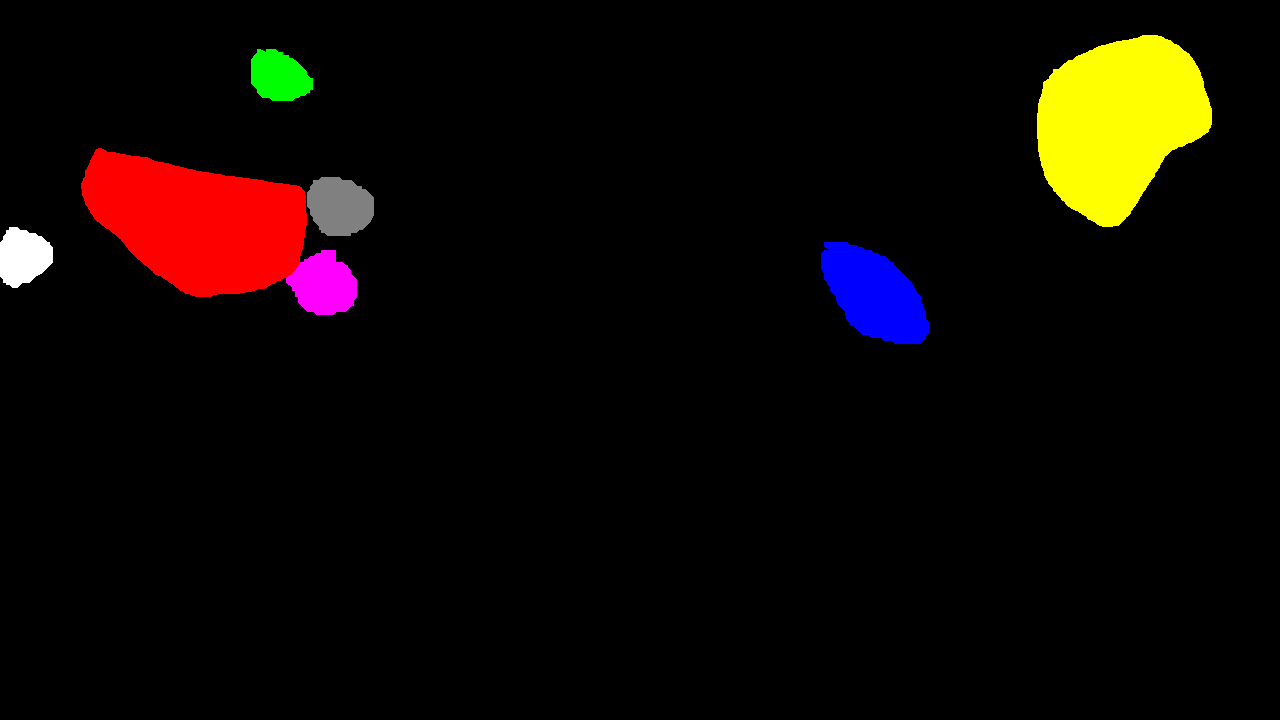

In [5]:
from PIL import Image

mask_path = os.path.join(MASKRCNN_DATASET_FOLDER, "masks", "mask_3.png")
mask = Image.open(mask_path)
mask = mask.convert('P')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0,       # index 0 is black background
    255, 0, 0,     # index 1 is red
    255, 255, 0,   # index 2 is yellow
    0, 255, 0,     # index 3 is green
    0, 0, 255,     # index 4 is blue
    255, 0, 255,   # index 5 is magenta
    128, 128, 128, # index 6 is gray
    255, 255, 255, # index 7 is white
    255, 128, 0,   # index 8 is orange
    70, 70, 70,    # index 9 is dark gray
    255, 153, 204, # index 10 is light pink
    0, 128, 128,   # index 11 is teal
    255, 153, 0,   # index 12 is dark yellow
    51, 204, 51,   # index 13 is lime green
    102, 51, 0,    # index 14 is brown
])

mask

# Custom Dataset

In [6]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class RocksDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # Load all image files, sorting them to ensure that they are aligned
        self.imgs = os.listdir(os.path.join(root, "images"))
        # Get the index of each image contained in the file name ('image_0.png', etc.)
        indices = [int(file_name.split("_")[1].split(".")[0]) for file_name in self.imgs if file_name.startswith("image_") and file_name.endswith(".png")]
        # Sort the image files by index
        self.imgs = ['image_' + str(i) + '.png' for i in sorted(indices)]


        # Do the same for the masks
        self.masks = os.listdir(os.path.join(root, "masks"))
        indices = [int(file_name.split("_")[1].split(".")[0]) for file_name in self.masks if file_name.startswith("mask_") and file_name.endswith(".png")]
        self.masks = ['mask_' + str(i) + '.png' for i in sorted(indices)]

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # print('obj_ids:', obj_ids, 'for index ', idx,'\n')
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Build the model

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## In case the required helper functions are not installed, uncomment this cell

In [8]:
# !git clone https://github.com/pytorch/vision.git
# %cd vision
# !git checkout v0.3.0

# !cp references/detection/utils.py ../
# !cp references/detection/transforms.py ../
# !cp references/detection/coco_eval.py ../
# !cp references/detection/engine.py ../
# !cp references/detection/coco_utils.py ../

# Create train and tests datasets, and data loaders

In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = RocksDataset(MASKRCNN_DATASET_FOLDER, get_transform(train=True))
dataset_test = RocksDataset(MASKRCNN_DATASET_FOLDER, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-test_size])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_size:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# Model, optimizer, and lr scheduler

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/home/paul-emile/anaconda3/envs/nasa-reachbot/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paul-emile/anaconda3/envs/nasa-reachbot/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train the model

In [11]:
# number of epochs
num_epochs = 10

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     evaluate(model, data_loader_test, device=device)
#     # save the model at the end of each epoch
#     torch.save(model.state_dict(), f"./models/maskrcnn_finetuned_model_epoch_{epoch}.pt")

# Save the model

In [12]:
# torch.save(model, 'mask-rcnn-pedestrian.pt')

# Inference

In [13]:
# load the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=2)
model.load_state_dict(torch.load(f'./models/maskrcnn_finetuned_model_epoch_{num_epochs-1}.pt'))
# set to evaluation mode
model.eval()
CLASS_NAMES = ['__background__', 'boulder']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [44]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence]
    print(pred_t)
    if pred_t == []:
        return [], [], []
    else:
        pred_t = pred_t[-1]
        masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
        # print(pred[0]['labels'].numpy().max())
        pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
        pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
        masks = masks[:pred_t+1]
        pred_boxes = pred_boxes[:pred_t+1]
        pred_class = pred_class[:pred_t+1]
        return masks, pred_boxes, pred_class

def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path, confidence)
    if masks == [] and boxes == [] and pred_cls == []:
        print('No boulders detected for this confidence threshold')
        return
    else:
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      for i in range(len(masks)):
        rgb_mask = get_coloured_mask(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])), color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
      plt.figure(figsize=(20,30))
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      plt.show()

## Example

[0]


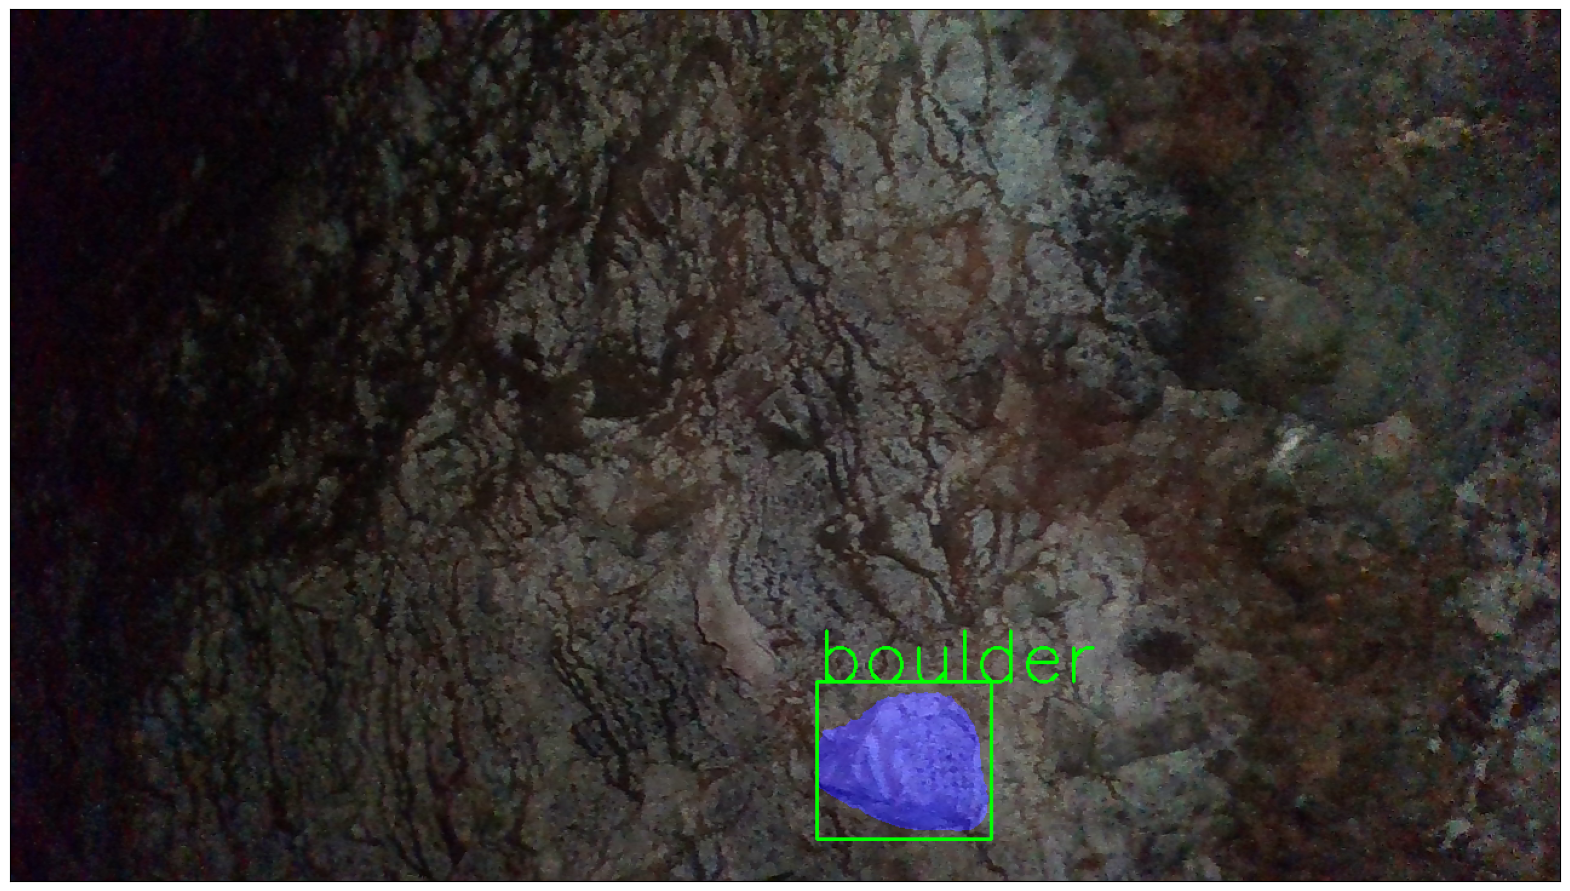

[0, 1, 2]


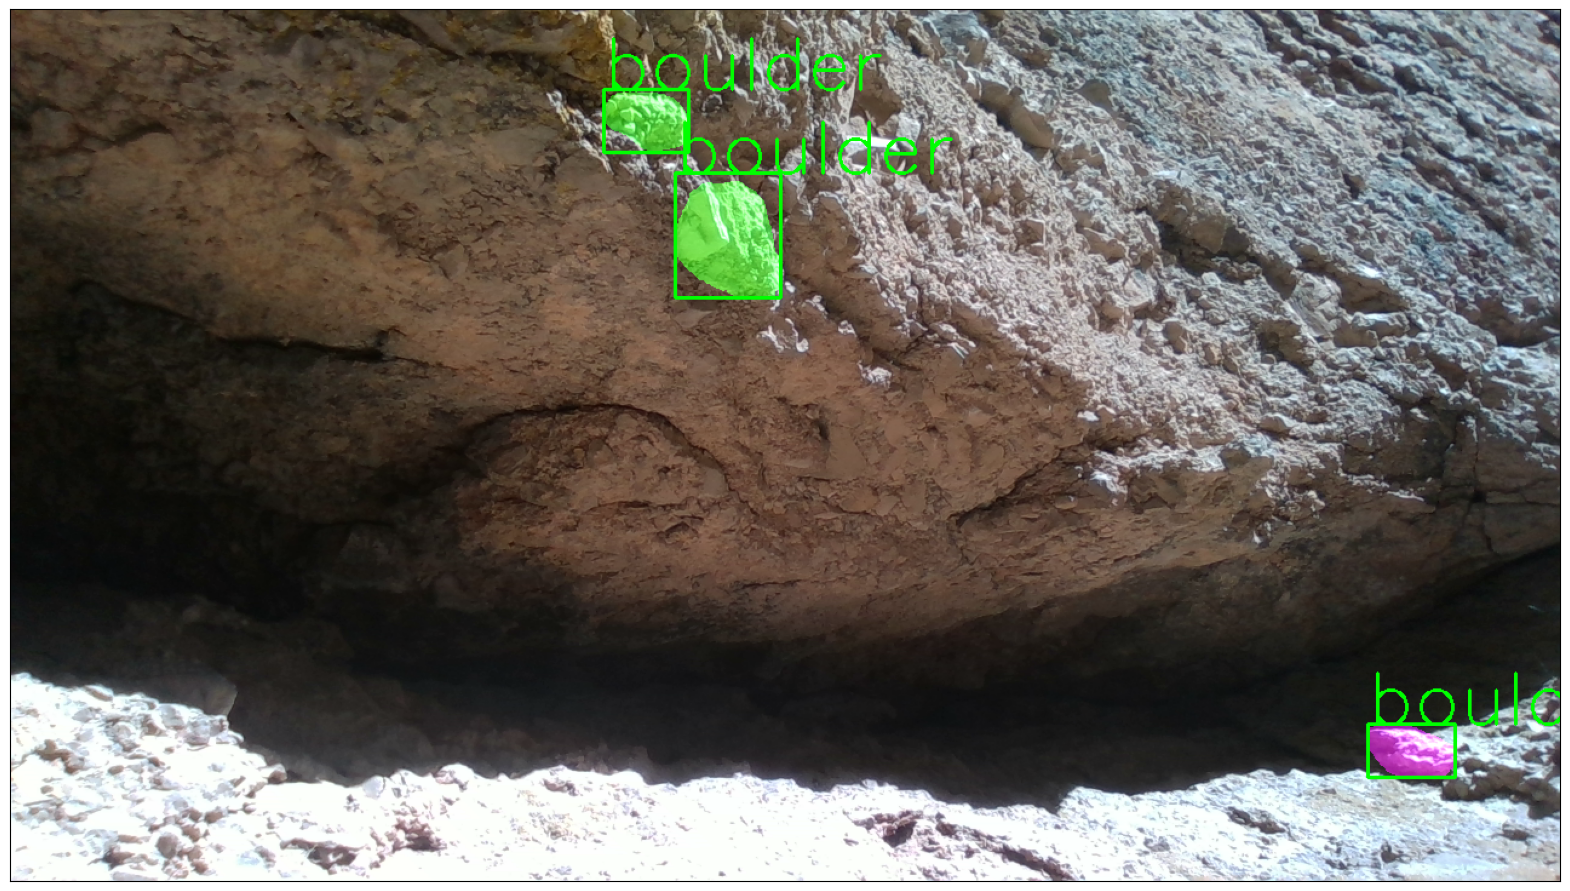

[0]


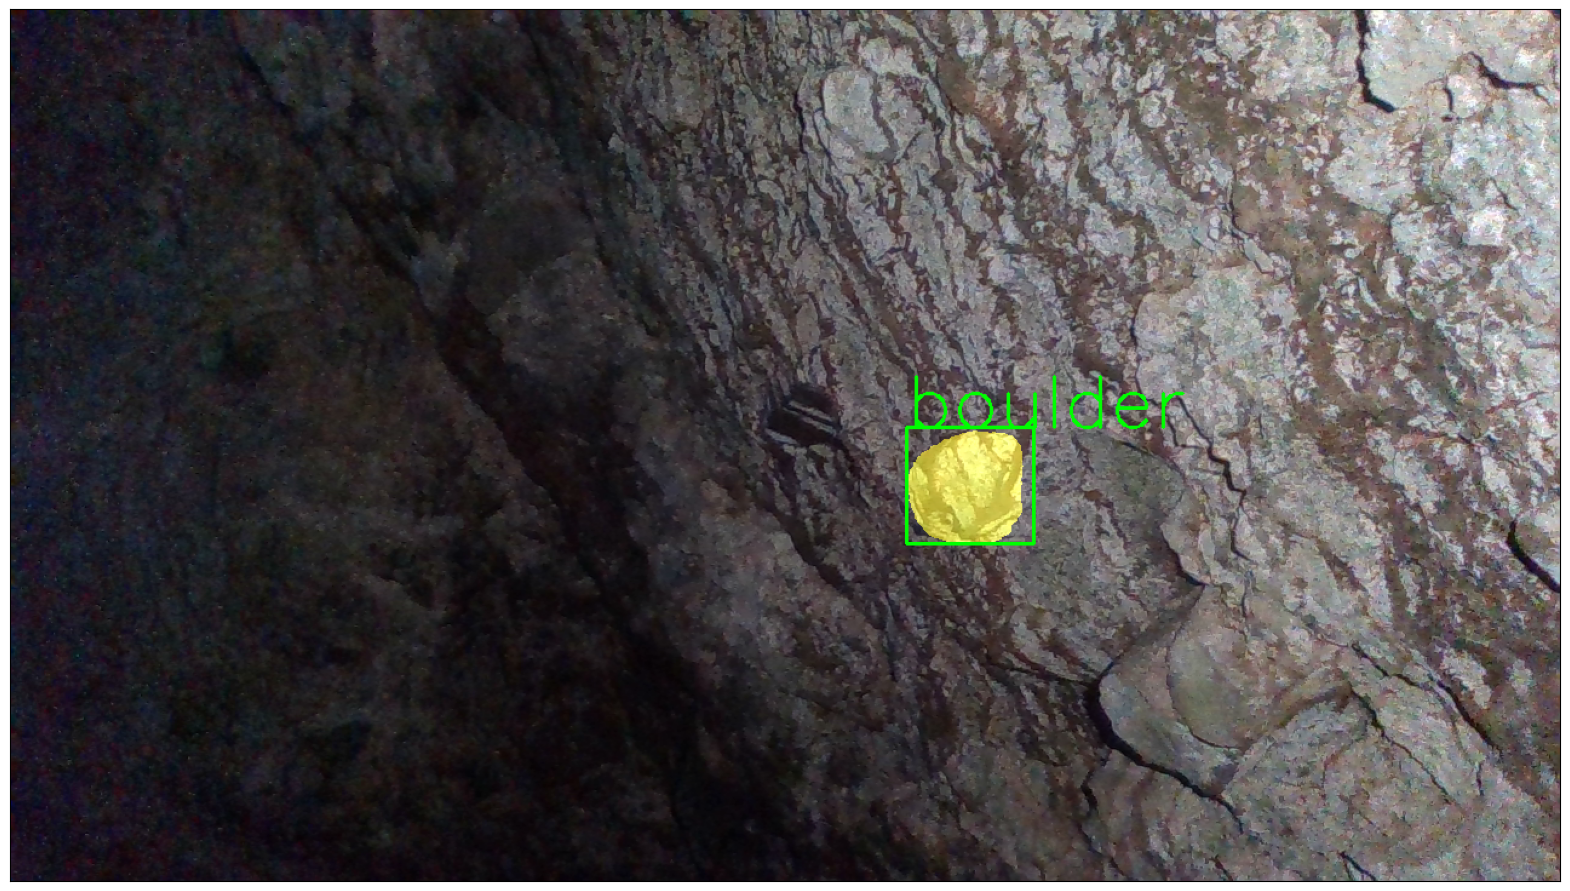

[]
No boulders detected for this confidence threshold
[]
No boulders detected for this confidence threshold


In [47]:
# Test the model on one image from the test set
num_test_images = 5

test_set_indices = indices[-test_size:]
for test_image_index in range(num_test_images):
    file_image_index = test_set_indices[test_image_index]
    if file_image_index not in test_set_indices:
        print('The image corresponding to the index is not present in the test dataset')
    else:
        test_image_path = f'./datasets/maskrcnn/images/image_{file_image_index}.png'
        segment_instance(test_image_path, confidence=0.6, rect_th=2, text_size=2, text_th=2)